# **1. Entendimiento del problema**

La Corporación de Reservas Estratégicas de Productos Perolíferos recopila y supervisa los datos del combustible en España. El objetivo principal del negocio consiste en anticipar el comportamiento del consumo de combustible para optimizar la planificación de recursos, gestionar de forma eficiente las reservas energética y apoyar la toma de decisiones políticas en el ámbito energético y medioambiental

# **2. Enfoque analítico**

Se realizará un estudio de series temporales analizando los patrones históricos del consumo mensual de combustible en España para generar modelos predictivos que permitan realizar pronósticos a mediano y largo plazo

# **3. Requerimiento de datos**

Consumo mensual histórico del combustible en España

In [2]:
!pip install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.0 MB/s eta 0:00:00


# **4. Recolección de datos**

In [3]:
import matplotlib.pyplot as plt
from skforecast.datasets import fetch_dataset
import pandas as pd

In [4]:
data = fetch_dataset('fuel_consumption')
data.index.name = 'gasoleos'

╭──────────────────────────────── fuel_consumption ────────────────────────────────╮
│ Description:                                                                     │
│ Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.                 │
│                                                                                  │
│ Source:                                                                          │
│ Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and │
│ Corporación de Derecho Público tutelada por el Ministerio para la Transición     │
│ Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas            │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/consumos-combustibles-mensual.csv                             │
│                                                                                  │
│ Shape: 644 rows x 5 columns                                                      │
╰──────────────────────────────────────────────────────────────────────────────────╯

In [5]:
data = data

In [6]:
start_pandemia = '2020-01-01'
end_pandemia   = '2022-08-01'

data = data.loc[~((data.index >= start_pandemia) & (data.index <= end_pandemia))]
data

,GLPs,Gasolinas,Querosenos,Gasoleos,Fueloleos
gasoleos,,,,,
1969-01-01,133615.09620,166875.2129,123257.8090,4.011853e+05,912583.4202
1969-02-01,126748.47410,155466.8105,114682.5767,3.853600e+05,851877.8115
1969-03-01,107795.80910,184983.6699,109970.0796,4.189556e+05,873884.2933
1969-04-01,96683.15967,202319.8164,108797.9255,4.389755e+05,755490.1170
1969-05-01,79506.23804,206259.1523,103554.0784,4.674519e+05,729963.6009
...,...,...,...,...,...
2019-08-01,171090.38000,526384.0700,690255.1500,2.502827e+06,686475.5700
2019-09-01,161838.73000,446302.0600,657335.5300,2.441542e+06,685567.6800
2019-10-01,190449.98000,471751.5600,617131.4400,2.795067e+06,605056.8600


# **5. Exploración de Datos**

- Identificar los patrones estacionales de la serie
- Determinar la estacionariedad de la serie

In [7]:
from skforecast.plot import set_dark_theme
set_dark_theme()

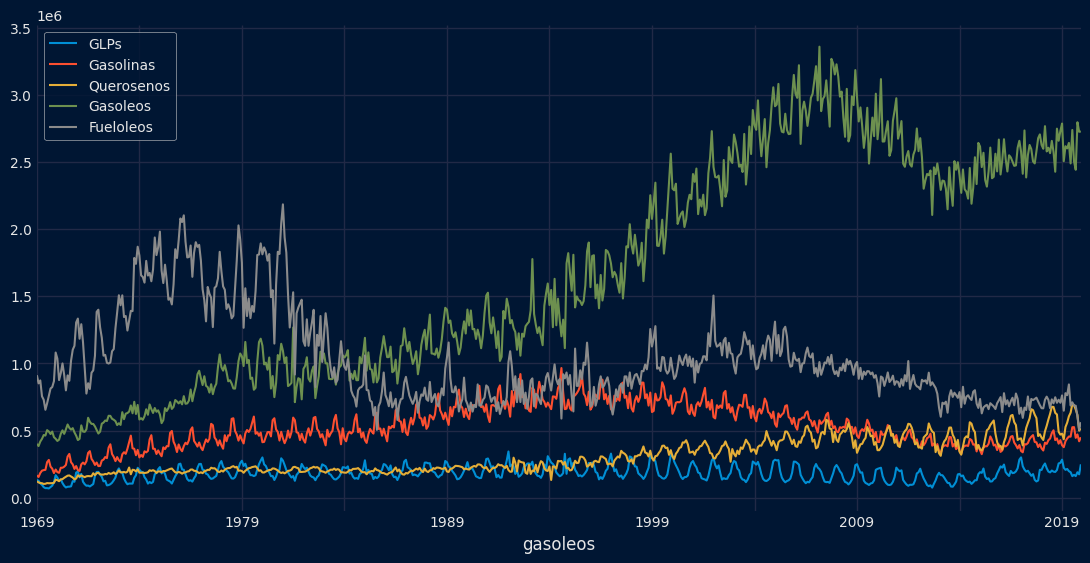

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(ax=ax)
ax.legend()
plt.show()

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

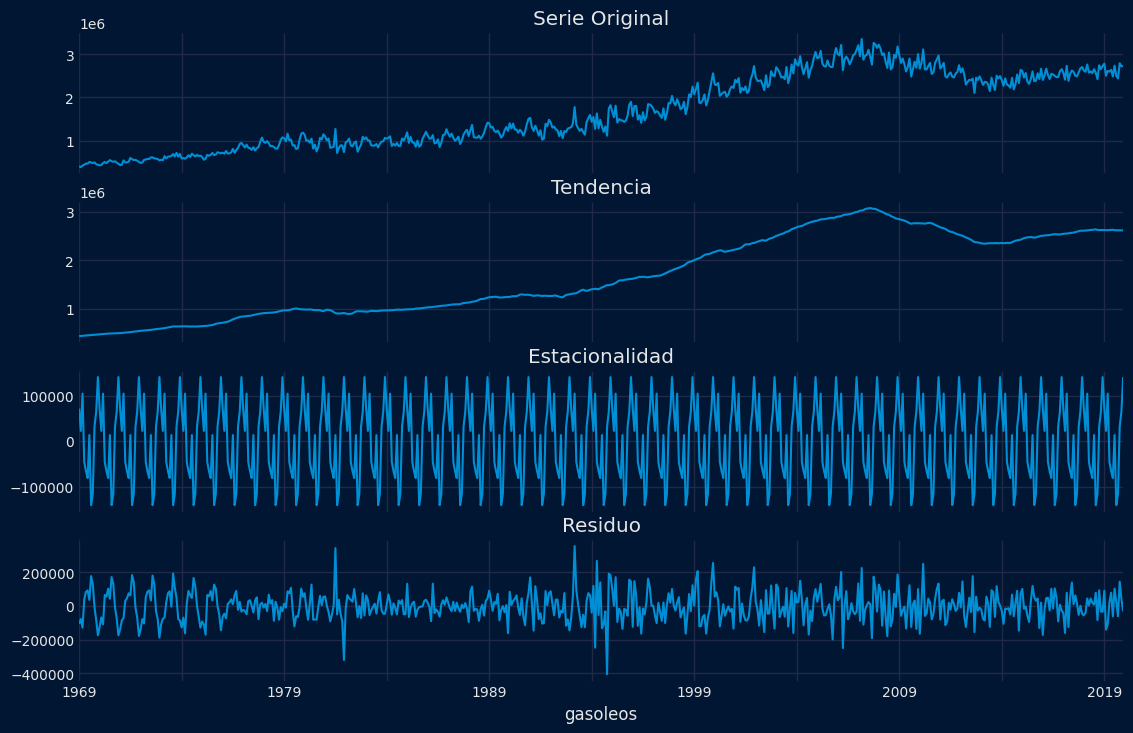

In [10]:
res_decompose = seasonal_decompose(data['Gasoleos'], model='additive', extrapolate_trend='freq')
fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
res_decompose.observed.plot(ax=ax[0])
ax[0].set_title('Serie Original')
res_decompose.trend.plot(ax=ax[1])
ax[1].set_title('Tendencia')
res_decompose.seasonal.plot(ax=ax[2])
ax[2].set_title('Estacionalidad')
res_decompose.resid.plot(ax=ax[3])
ax[3].set_title('Residuo')
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
print('Test Estacionariedad de Dickey-Fuller Aumentado')
result = adfuller(data['Gasoleos'])
print('ADF Estadístico:', result[0])
print('Valor p:', result[1])

Test Estacionariedad de Dickey-Fuller Aumentado
ADF Estadístico: -1.0214591867514446
Valor p: 0.7453573191240492


# **6. Preparación de los Datos**

## Diferenciación de la serie

Cantidad de veces que se transformó la serie para ser estacionaria
- 1 movimiento, d = 1

Test Estacionariedad de Dickey-Fuller Aumentado
ADF Estadístico: -3.408067884438755
Valor p: 0.01068689351856062


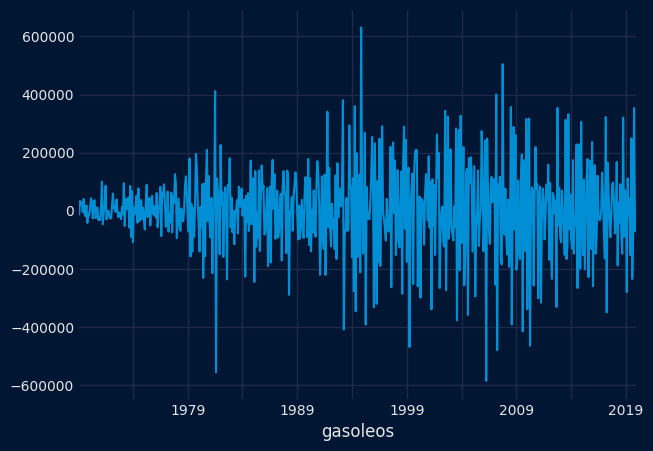

In [13]:
data_diff = data['Gasoleos'].diff().dropna()
print('Test Estacionariedad de Dickey-Fuller Aumentado')
result = adfuller(data_diff)
print('ADF Estadístico:', result[0])
print('Valor p:', result[1])
data_diff.plot()
plt.show()

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Función de Autocorrelación

Cantidad de retornos de la parte autoagresiva
- q = 1

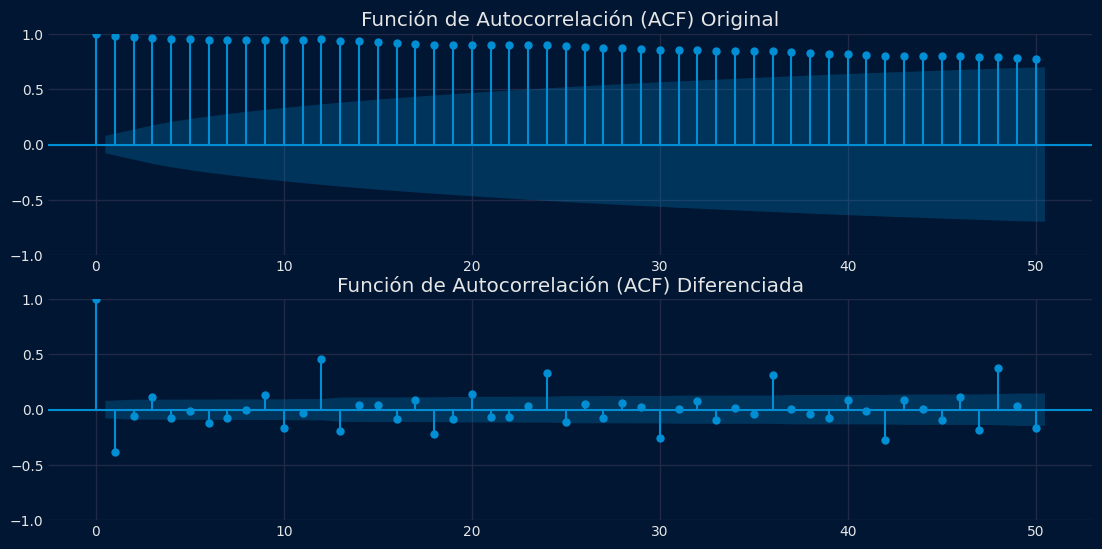

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(data['Gasoleos'], lags=50, ax=ax[0], alpha=0.05)
ax[0].set_title('Función de Autocorrelación (ACF) Original')
plot_acf(data_diff, lags=50, ax=ax[1], alpha=0.05)
ax[1].set_title('Función de Autocorrelación (ACF) Diferenciada')
plt.show()

## Función de Autocorrelación Parcial

Tamaño de la ventana del proceso de media móvil
- p = 2

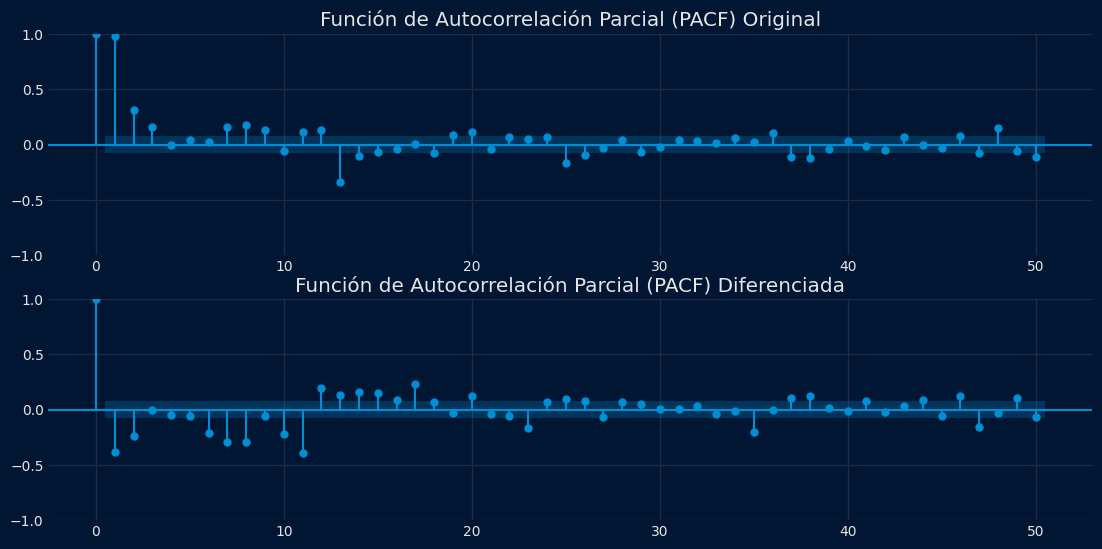

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_pacf(data['Gasoleos'], lags=50, ax=ax[0], alpha=0.05)
ax[0].set_title('Función de Autocorrelación Parcial (PACF) Original')
plot_pacf(data_diff, lags=50, ax=ax[1], alpha=0.05)
ax[1].set_title('Función de Autocorrelación Parcial (PACF) Diferenciada')
plt.show()

## Diferenciación de la Serie Estacional

**D = 1**

In [81]:
data_diff_12 = data['Gasoleos'].diff().diff(12).dropna()
adfuller_result = adfuller(data_diff_12)
print('Test Estacionariedad de Dickey-Fuller Aumentado')
print('ADF Estadístico:', adfuller_result[0])
print('Valor p:', adfuller_result[1])

Test Estacionariedad de Dickey-Fuller Aumentado
ADF Estadístico: -8.619960938154042
Valor p: 6.143107353935201e-14


## Función de Autocorrelación Estacional

**Q = 1**

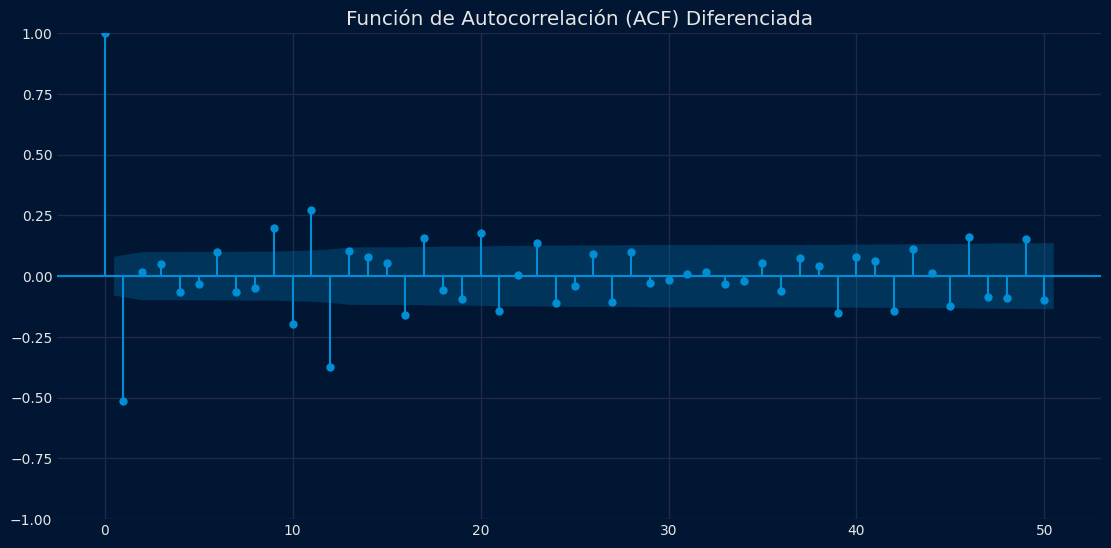

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(data_diff_12, lags=50, ax=ax, alpha=0.05)
ax.set_title('Función de Autocorrelación (ACF) Diferenciada')
plt.show()

## Función de Autocrrelación Parcial Estacional

**P = 8**

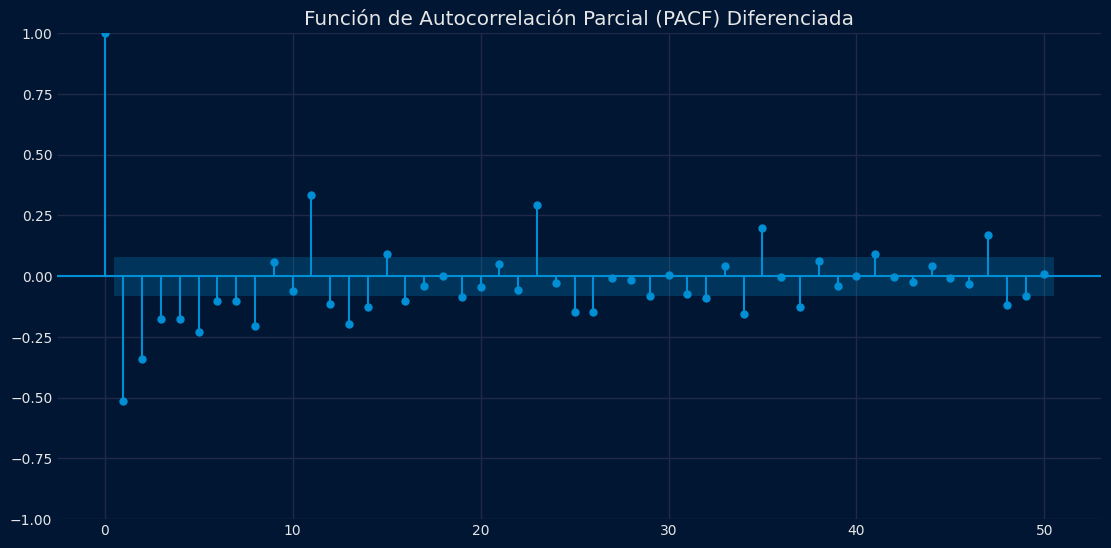

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(data_diff_12, lags=50, ax=ax, alpha=0.05)
ax.set_title('Función de Autocorrelación Parcial (PACF) Diferenciada')
plt.show()

## Conjunto de entrenamiento

In [68]:
end_train = '2010-01-01'
data_train = data["Gasoleos"].loc[:end_train]
data_test = data["Gasoleos"].loc[end_train:]

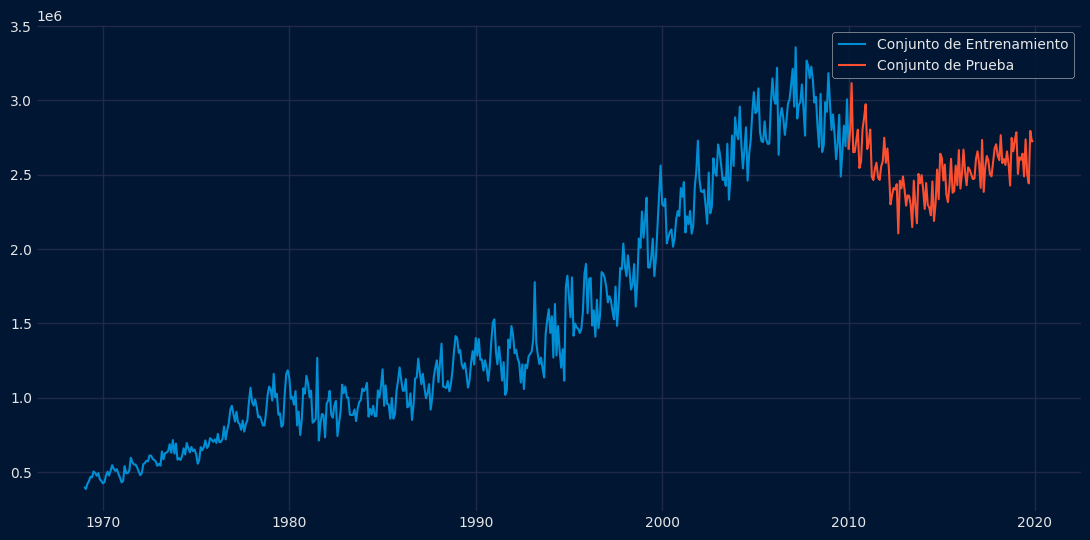

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(data_train, label='Conjunto de Entrenamiento')
plt.plot(data_test, label='Conjunto de Prueba')
plt.legend()
plt.show()

# **7. Modelos**

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from skforecast.plot import plot_prediction_intervals

## SARIMAX

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [70]:
modelo_sarimax = SARIMAX(data_train, order=(2, 1, 1), seasonal_order=(8, 1, 1, 12))
modelo_sarimax = modelo_sarimax.fit(disp=0)
modelo_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Gasoleos   No. Observations:                  493
Model:             SARIMAX(2, 1, 1)x(8, 1, 1, 12)   Log Likelihood               -6223.030
Date:                            Sun, 26 Oct 2025   AIC                          12472.060
Time:                                    22:56:10   BIC                          12526.319
Sample:                                01-01-1969   HQIC                         12493.388
                                     - 01-01-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0260      0.133      0.195      0.845      -0.235       0.287
ar.L2          0.0465      0.116      0.402      0.687      -0.180       0.273
ma.L1         -0.7246      0.119     -6.102      0.000      -0.957      -0.492
ar.S.L12      -0.8777      1.849     -0.475      0.635      -4.502       2.747
ar.S.L24      -0.7550      1.410     -0.535      0.592      -3.519       2.009
ar.S.L36      -0.6093      1.232     -0.495      0.621      -3.024       1.805
ar.S.L48      -0.4907      1.002     -0.490      0.624      -2.455       1.473
ar.S.L60      -0.2465      0.827     -0.298      0.766      -1.868       1.375
ar.S.L72       0.0079      0.426      0.019      0.985      -0.827       0.843
ar.S.L84       0.0375      0.121      0.311      0.756      -0.199       0.274
ar.S.L96       0.0470      0.099      0.476      0.634      -0.146       0.241
ma.S.L12       0.1217      1.850      0.066      0.948      -3.504       3.747
sigma2      1.598e+10   9.38e-10    1.7e+19      0.000     1.6e+10     1.6e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                71.82
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.49e+35. Standard errors may be unstable.
"""

In [71]:
pred_sarimax = modelo_sarimax.get_forecast(steps=len(data_test)).predicted_mean
pred_sarimax.name = 'predicciones_sarimax'
pred_sarimax

,predicciones_sarimax
2010-02-01,2.735567e+06
2010-03-01,2.899722e+06
2010-04-01,2.641504e+06
2010-05-01,2.564624e+06
2010-06-01,2.616892e+06
...,...
2019-09-01,2.186249e+06
2019-10-01,2.428255e+06
2019-11-01,2.405537e+06
2019-12-01,2.574060e+06


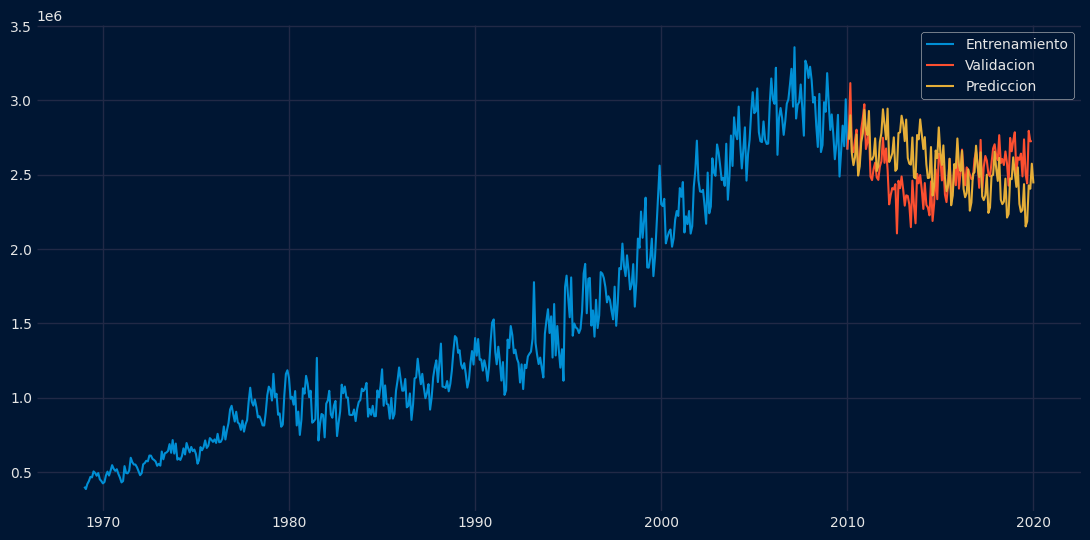

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(data_train, label="Entrenamiento")
plt.plot(data_test, label="Validacion")
plt.plot(pred_sarimax, label="Prediccion")
plt.legend()
plt.show()

In [73]:
from sklearn.metrics import mean_absolute_percentage_error
mape_sarimax = mean_absolute_percentage_error(data_test, pred_sarimax)
mape_sarimax

0.08330896895930194

## Regresión Lineal

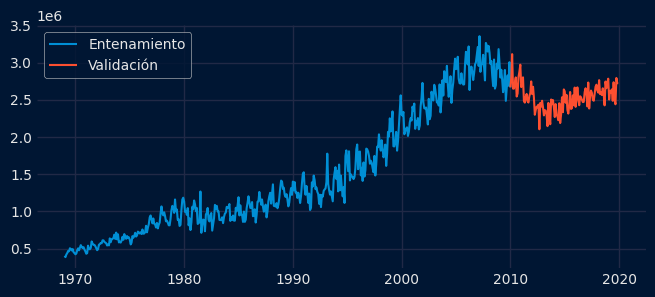

In [28]:
plt.figure(figsize=(7,3))
plt.plot(data_train, label = 'Entenamiento')
plt.plot(data_test, label = 'Validación')
plt.legend()
plt.show()

In [92]:
forecaster1 = ForecasterRecursive(regressor= LinearRegression(),
                                   lags = 12, window_features= RollingFeatures(stats=['mean'], window_sizes = 12))
forecaster1.fit(y = data_train, store_in_sample_residuals=True)
forecaster1

=================== 
ForecasterRecursive 
=================== 
Regressor: LinearRegression 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Window features: ['roll_mean_12'] 
Window size: 12 
Series name: Gasoleos 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1969-01-01 00:00:00'), Timestamp('2010-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False} 
fit_kwargs: {} 
Creation date: 2025-10-26 23:26:26 
Last fit date: 2025-10-26 23:26:26 
Skforecast version: 0.18.0 
Python version: 3.12.12 
Forecaster id: None

In [93]:
predictions1 = forecaster1.predict(steps = len(data_test))
predictions1

,pred
2010-02-01,2.844999e+06
2010-03-01,2.923134e+06
2010-04-01,2.814317e+06
2010-05-01,2.724294e+06
2010-06-01,2.813045e+06
...,...
2019-09-01,3.499752e+06
2019-10-01,3.506569e+06
2019-11-01,3.514341e+06
2019-12-01,3.522657e+06


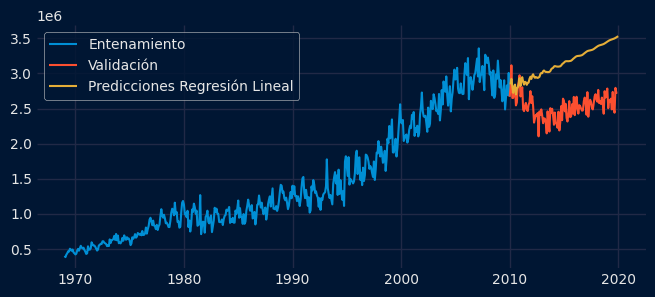

In [94]:
plt.figure(figsize=(7,3))
plt.plot(data_train, label = 'Entenamiento')
plt.plot(data_test, label = 'Validación')
plt.plot(predictions1, label = 'Predicciones Regresión Lineal')
plt.legend()
plt.show()

In [32]:
mean_absolute_percentage_error(data_test, predictions1)

0.21476327836895456

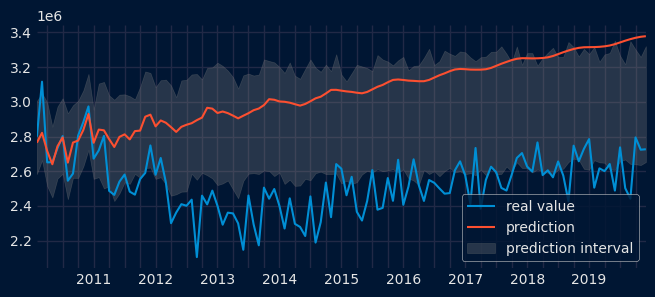

In [33]:
predictions1_interval = forecaster1.predict_interval(steps= len(data_test) - 1, interval = [5,95],
                                                     method = 'bootstrapping', n_boot = 100)
plot_prediction_intervals(predictions=predictions1_interval, y_true=data_test, target_variable= 'Gasoleos',
                           kwargs_fill_between={'color': 'gray', 'alpha':0.3})

## Árbol de Decisión

In [88]:
forecaster2 = ForecasterRecursive(regressor= DecisionTreeRegressor(random_state=42),
                                   lags = 12, window_features= RollingFeatures(stats=['mean'], window_sizes = 12))
forecaster2.fit(y = data_train, store_in_sample_residuals=True)
forecaster2

=================== 
ForecasterRecursive 
=================== 
Regressor: DecisionTreeRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Window features: ['roll_mean_12'] 
Window size: 12 
Series name: Gasoleos 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1969-01-01 00:00:00'), Timestamp('2010-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None,
    'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf':
    0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2025-10-26 23:23:43 
Last fit date: 2025-10-26 23:23:43 
Skforecast version: 0.18.0 
Python version: 3.12.12 
Forecaster id: None

In [89]:
predictions2 = forecaster2.predict(steps = len(data_test))
predictions2

,pred
2010-02-01,2948524.227
2010-03-01,2691444.970
2010-04-01,2734863.502
2010-05-01,2919179.340
2010-06-01,2719703.833
...,...
2019-09-01,2691444.970
2019-10-01,3007661.350
2019-11-01,2706787.520
2019-12-01,2923085.600


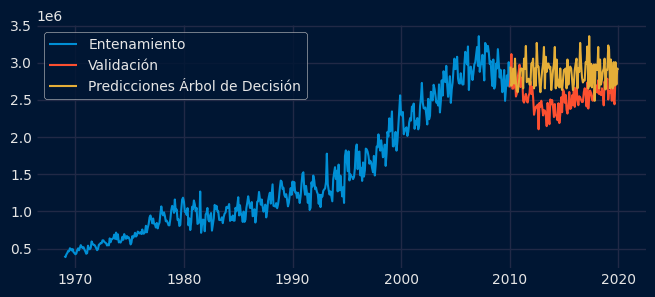

In [90]:
plt.figure(figsize=(7,3))
plt.plot(data_train, label = 'Entenamiento')
plt.plot(data_test, label = 'Validación')
plt.plot(predictions2, label = 'Predicciones Árbol de Decisión')
plt.legend()
plt.show()

In [91]:
mean_absolute_percentage_error(data_test, predictions2)

0.14610387261353577

In [38]:
data.loc

In [101]:
from skforecast.model_selection import grid_search_forecaster, random_search_forecaster, TimeSeriesFold
forecaster2 = ForecasterRecursive(regressor= DecisionTreeRegressor(random_state=42),
                                  lags = 12)
lags_grid = {'lags_1':3, 'lags_2':[12], 'lags_3':[1,2,3,12]}
param_grid = {'max_depth':[5,10,20], 'criterion':['squared_error', 'poisson', 'absolute_error', 'friedman_mse']}
cv = TimeSeriesFold(steps = 12, initial_train_size = len(data_test), refit = False)
results = grid_search_forecaster(forecaster=forecaster2,
                                 y=data_train, param_grid=param_grid, lags_grid=lags_grid, cv=cv, metric= 'mean_squared_error',
                                 return_best=True, n_jobs=-1, verbose=False, show_progress=True)
results

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [12] 
  Parameters: {'criterion': 'squared_error', 'max_depth': 5}
  Backtesting metric: 983243675754.9083


,lags,lags_label,params,mean_squared_error,criterion,max_depth
0,[12],lags_2,"{'criterion': 'squared_error', 'max_depth': 5}",9.832437e+11,squared_error,5
1,[12],lags_2,"{'criterion': 'poisson', 'max_depth': 5}",9.832437e+11,poisson,5
2,[12],lags_2,"{'criterion': 'friedman_mse', 'max_depth': 5}",9.832437e+11,friedman_mse,5
3,[12],lags_2,"{'criterion': 'squared_error', 'max_depth': 10}",9.832515e+11,squared_error,10
4,[12],lags_2,"{'criterion': 'poisson', 'max_depth': 10}",9.832515e+11,poisson,10
5,[12],lags_2,"{'criterion': 'friedman_mse', 'max_depth': 10}",9.832515e+11,friedman_mse,10
6,[12],lags_2,"{'criterion': 'absolute_error', 'max_depth': 10}",9.832693e+11,absolute_error,10
7,[12],lags_2,"{'criterion': 'absolute_error', 'max_depth': 5}",9.832733e+11,absolute_error,5
8,[12],lags_2,"{'criterion': 'friedman_mse', 'max_depth': 20}",9.833306e+11,friedman_mse,20
9,[12],lags_2,"{'criterion': 'absolute_error', 'max_depth': 20}",9.833306e+11,absolute_error,20


In [102]:
forecaster2

=================== 
ForecasterRecursive 
=================== 
Regressor: DecisionTreeRegressor 
Lags: [12] 
Window features: None 
Window size: 12 
Series name: Gasoleos 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1969-01-01 00:00:00'), Timestamp('2010-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features':
    None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf':
    0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2025-10-26 23:30:02 
Last fit date: 2025-10-26 23:30:11 
Skforecast version: 0.18.0 
Python version: 3.12.12 
Forecaster id: None

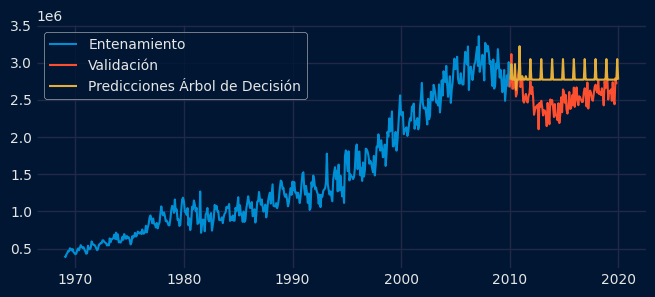

In [103]:
predictions2 = forecaster2.predict(len(data_test))
plt.figure(figsize=(7,3))
plt.plot(data_train, label = 'Entenamiento')
plt.plot(data_test, label = 'Validación')
plt.plot(predictions2, label = 'Predicciones Árbol de Decisión')
plt.legend()
plt.show()

In [104]:
mean_absolute_percentage_error(data_test, predictions2)

0.11417361292779961

## Bosques Aleatorios

In [109]:
from skforecast.model_selection import grid_search_forecaster, random_search_forecaster, TimeSeriesFold
forecaster3 = ForecasterRecursive(regressor= RandomForestRegressor(random_state=42), lags = 10)
lags_grid = {'lags_1':3, 'lags_2':10, 'lags_3':[1,2,3,12]}
param_grid = {'max_depth':[5,10,20], 'criterion':['squared_error', 'poisson', 'absolute_error', 'friedman_mse'], 'n_estimators':[100,200,300]}
cv = TimeSeriesFold(steps = 12, initial_train_size = len(data_test), refit = False)
results = grid_search_forecaster(forecaster=forecaster3,
                                 y=data_train, param_grid=param_grid, lags_grid=lags_grid, cv=cv, metric= 'mean_squared_error',
                                 return_best=True, n_jobs=-1, verbose=False, show_progress=True)
results

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 12] 
  Parameters: {'criterion': 'absolute_error', 'max_depth': 20, 'n_estimators': 100}
  Backtesting metric: 1013792416183.206


,lags,lags_label,params,mean_squared_error,criterion,max_depth,n_estimators
0,"[1, 2, 3, 12]",lags_3,"{'criterion': 'absolute_error', 'max_depth': 2...",1.013792e+12,absolute_error,20,100
1,"[1, 2, 3, 12]",lags_3,"{'criterion': 'squared_error', 'max_depth': 20...",1.015074e+12,squared_error,20,100
2,"[1, 2, 3, 12]",lags_3,"{'criterion': 'absolute_error', 'max_depth': 2...",1.015416e+12,absolute_error,20,200
3,"[1, 2, 3, 12]",lags_3,"{'criterion': 'squared_error', 'max_depth': 20...",1.015795e+12,squared_error,20,200
4,"[1, 2, 3, 12]",lags_3,"{'criterion': 'squared_error', 'max_depth': 20...",1.015822e+12,squared_error,20,300
...,...,...,...,...,...,...,...
103,"[1, 2, 3]",lags_1,"{'criterion': 'poisson', 'max_depth': 5, 'n_es...",1.272633e+12,poisson,5,100
104,"[1, 2, 3]",lags_1,"{'criterion': 'poisson', 'max_depth': 10, 'n_e...",1.273496e+12,poisson,10,100
105,"[1, 2, 3]",lags_1,"{'criterion': 'poisson', 'max_depth': 20, 'n_e...",1.274339e+12,poisson,20,200
106,"[1, 2, 3]",lags_1,"{'criterion': 'poisson', 'max_depth': 10, 'n_e...",1.274813e+12,poisson,10,200


In [110]:
forecaster3

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [ 1  2  3 12] 
Window features: None 
Window size: 12 
Series name: Gasoleos 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1969-01-01 00:00:00'), Timestamp('2010-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'absolute_error',
    'max_depth': 20, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples':
    None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1,
    'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst':
    None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False,
    'random_state': 42, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-10-26 23:50:58 
Last fit date: 2025-10-27 00:07:01 
Skforecast version: 0.18.0 
Python version: 3.12.12 
Forecaster id: None

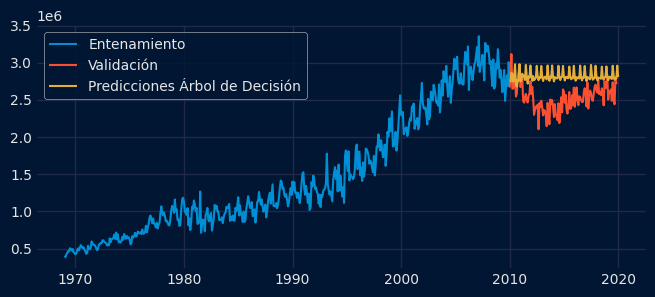

In [111]:
predictions3 = forecaster3.predict(len(data_test))
plt.figure(figsize=(7,3))
plt.plot(data_train, label = 'Entenamiento')
plt.plot(data_test, label = 'Validación')
plt.plot(predictions3, label = 'Predicciones Árbol de Decisión')
plt.legend()
plt.show()

In [112]:
mean_absolute_percentage_error(data_test, predictions3)

0.12123903497194705

## Redes Neuronales Recurrentes

In [ ]:
!pip install keras tensorflow

In [169]:
end_train = '2006-07-01'
data_train_rnn = data["Gasoleos"].loc[:end_train]
data_test_rnn = data["Gasoleos"].loc[end_train:]

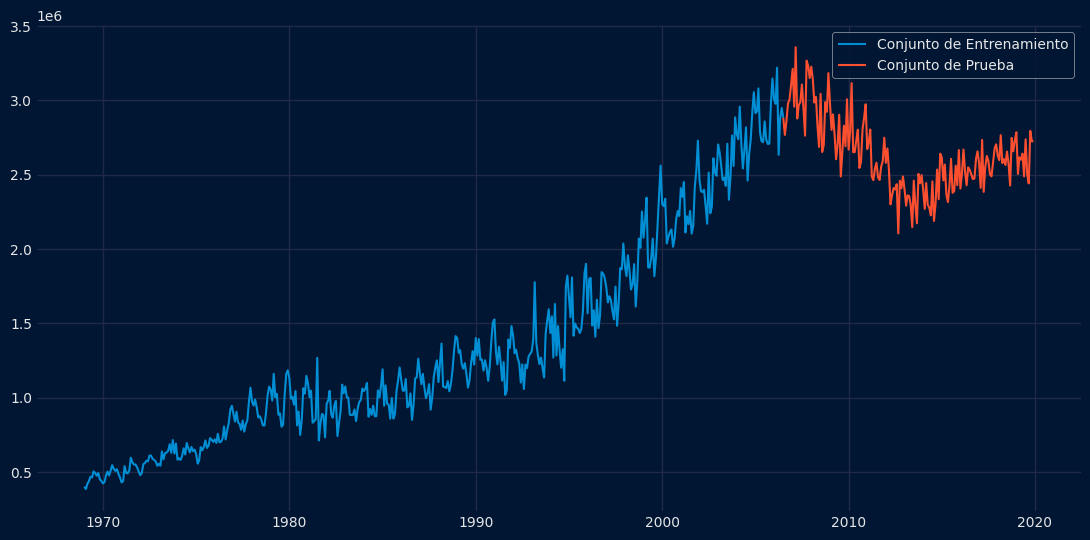

In [170]:
plt.figure(figsize=(12, 6))
plt.plot(data_train_rnn, label='Conjunto de Entrenamiento')
plt.plot(data_test_rnn, label='Conjunto de Prueba')
plt.legend()
plt.show()

In [48]:
from skforecast.deep_learning import ForecasterRnn, create_and_compile_model
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [203]:
model_rna = create_and_compile_model(series = pd.DataFrame(data_train_rnn),
                                     levels = ['Gasoleos'], lags = 6, steps = 1,
                                     recurrent_layer='RNN',
                                     recurrent_units = 100,
                                     dense_units = 64)
model_rna.summary()

keras version: 3.10.0
Using backend: tensorflow
tensorflow version: 2.19.0



Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ series_input (InputLayer)       │ (None, 6, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_1 (SimpleRNN)               │ (None, 100)            │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_td_layer (Dense)   │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,729 (65.35 KB)

 Trainable params: 16,729 (65.35 KB)

 Non-trainable params: 0 (0.00 B)

In [204]:
forecaster_5 = ForecasterRnn(regressor = model_rna, lags=6,
                             levels = ['Gasoleos'],
                             transformer_series = MinMaxScaler(),
                             fit_kwargs = {'epochs': 25,
                                           'batch_size': 512, #entre mas grande, mas lento
                                           'callbacks': [EarlyStopping(monitor = 'val_loss', restore_best_weights = True)],
                                           'series_val': pd.DataFrame(data_test_rnn)})
forecaster_5.fit(pd.DataFrame(data_train_rnn))

Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0721 - val_loss: 0.0285
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0082 - val_loss: 0.0239
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0173 - val_loss: 0.0442


In [186]:
forecaster_5

============= 
ForecasterRnn 
============= 
Regressor: <Functional name=functional_8, built=True> 
Layers names: ['series_input', 'rnn_1', 'dense_1', 'output_dense_td_layer', 'reshape'] 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Maximum steps to predict: [1] 
Series names: Gasoleos 
Target series (levels): ['Gasoleos'] 
Exogenous included: False 
Exogenous names: None 
Transformer for series: MinMaxScaler() 
Transformer for exog: MinMaxScaler() 
Training range: [Timestamp('1969-01-01 00:00:00'), Timestamp('2006-07-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'name': 'functional_8', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 24, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'series_input'}, 'registered_name': None, 'name': 'series_input', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'SimpleRNN', 'config': {'name': 'rnn_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 100, 'activation': 'tanh', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'Orthogonal', 'config': {'seed': None, 'gain': 1.0}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 1]}, 'name': 'rnn_1', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 24, 1), 'dtype': 'float32', 'keras_history': ['series_input', 0, 0]}},), 'kwargs': {'training': False, 'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 100]}, 'name': 'dense_1', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 100), 'dtype': 'float32', 'keras_history': ['rnn_1', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'output_dense_td_layer', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}, 'name': 'output_dense_td_layer', 'inbound_nodes': [{'args': 

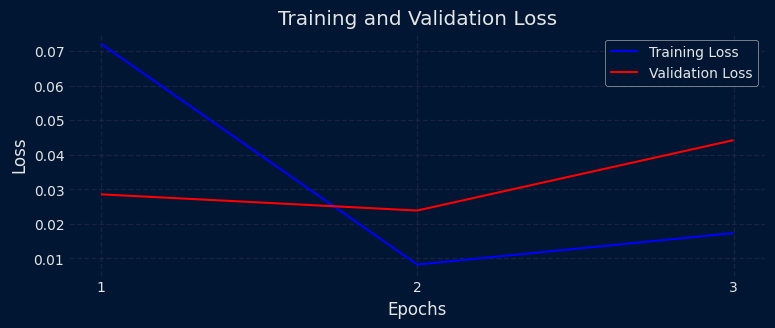

In [205]:
fig, ax = plt.subplots(figsize=(8, 3))
plot = forecaster_5.plot_history(ax=ax)

In [206]:
from skforecast.model_selection import backtesting_forecaster_multiseries
cv = TimeSeriesFold(steps = forecaster_5.max_step,
                    initial_train_size = len(data_train_rnn),
                    refit = False)
metrics, predictions_5 = backtesting_forecaster_multiseries(forecaster = forecaster_5,
                                                            series = pd.DataFrame(data['Gasoleos']),
                                                            cv = cv, levels = forecaster_5.levels,
                                                            metric = 'mean_absolute_percentage_error', verbose = False)

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0173 - val_loss: 0.0127
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0110 - val_loss: 0.0033
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0045 - val_loss: 0.0140


  0%|          | 0/161 [00:00<?, ?it/s]

In [207]:
metrics

,levels,mean_absolute_percentage_error
0,Gasoleos,0.049312


In [208]:
predictions_5

,level,fold,pred
2006-08-01,Gasoleos,0,2813769.50
2006-09-01,Gasoleos,1,2795351.00
2006-10-01,Gasoleos,2,2745600.25
2006-11-01,Gasoleos,3,2789938.50
2006-12-01,Gasoleos,4,2794197.00
...,...,...,...
2019-08-01,Gasoleos,156,2599378.75
2019-09-01,Gasoleos,157,2586259.25
2019-10-01,Gasoleos,158,2592672.50
2019-11-01,Gasoleos,159,2602392.50


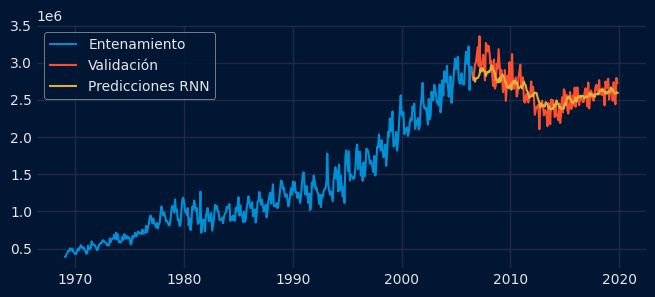

In [209]:
plt.figure(figsize=(7,3))
plt.plot(data_train_rnn, label = 'Entenamiento')
plt.plot(data_test_rnn, label = 'Validación')
plt.plot(predictions_5['pred'], label = 'Predicciones RNN')
plt.legend()
plt.show()

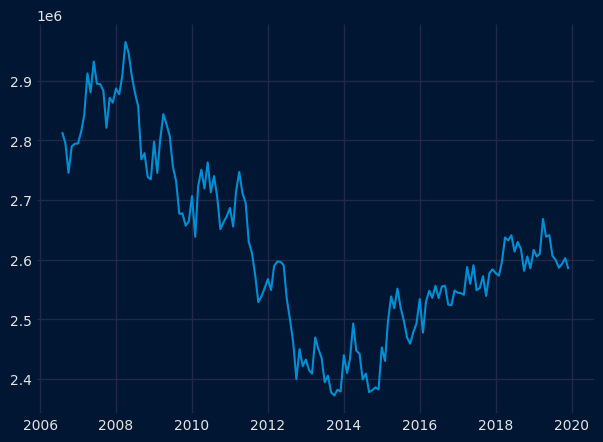

In [212]:
plt.plot(predictions_5['pred'], label = 'Predicciones RNN')